In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator
from jax import numpy as jnp
import jax

# Bio-heat equation

We want to solve

$$
\nabla^2 u = s
$$

in 2D. We further assume zero Dirichlet boundary conditions (uninsulated).

In [2]:
from jaxdf.operators import laplacian

domain = Domain((128,128), (1., 1.))

@operator()
def heat_eq(u):
    return laplacian(u)

In [3]:
from jaxdf.discretization import RealFourierSeries
from jaxdf.core import Field

# Initialize discretizations
fourier_discr = RealFourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params, u = fourier_discr.empty_field(name='u')
src_fourier_params, src = fourier_discr.empty_field(name='src')
src_fourier_params = src_fourier_params.at[32:36,32:42].set(1.)  # Source field, using Fourier discretization

In [4]:
Hu = heat_eq(u=u)

print(Hu)

DiscretizedOperator :: [RealFourierSeries], ['_k5'] 

 Input fields: ('u',)

Globals: Shared: {'k_vec': [DeviceArray([0.        , 0.04908739, 0.09817477, 0.14726216, 0.19634955,
             0.24543694, 0.2945243 , 0.34361172, 0.3926991 , 0.44178647,
             0.49087387, 0.5399613 , 0.5890486 , 0.638136  , 0.68722343,
             0.7363108 , 0.7853982 , 0.8344856 , 0.88357294, 0.93266034,
             0.98174775, 1.0308352 , 1.0799226 , 1.1290098 , 1.1780972 ,
             1.2271847 , 1.276272  , 1.3253595 , 1.3744469 , 1.4235342 ,
             1.4726216 , 1.521709  , 1.5707964 , 1.6198838 , 1.6689712 ,
             1.7180586 , 1.7671459 , 1.8162333 , 1.8653207 , 1.9144081 ,
             1.9634955 , 2.0125828 , 2.0616703 , 2.1107576 , 2.159845  ,
             2.2089324 , 2.2580197 , 2.3071072 , 2.3561945 , 2.405282  ,
             2.4543693 , 2.5034568 , 2.552544  , 2.6016314 , 2.650719  ,
             2.6998062 , 2.7488937 , 2.797981  , 2.8470683 , 2.8961558 ,
             2.9452

In [5]:
# Make the computational graph
Hu = heat_eq(u=u)
global_params = Hu.get_global_params()

# hack to force BC using padding
small_src = src_fourier_params[1:-1,1:-1,:]
@jax.jit
def heat_func(u):
    u = jnp.pad(u,((1,1),(1,1),(0,0)))
    
    f = Hu.get_field_on_grid(0)
    
    op_image = f(
        global_params,
        {"u":u}
    )
    
    return op_image[1:-1,1:-1,:]

In [6]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(heat_func, -small_src, maxiter=1000, restart=25)

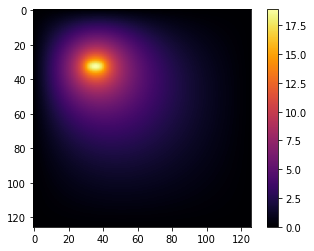

In [7]:
plt.imshow(sol, cmap="inferno", vmin=0.)
plt.colorbar()

# Solving using PINNs

In [8]:
from jaxdf.core import Field

from jaxdf.discretization import Arbitrary, UniformField
from jax.experimental import stax
from jax import random

seed = random.PRNGKey(42)

# Make a neural network for the field discretization
nonlin = stax.elementwise(jnp.tanh)
init_random_params, predict = stax.serial(
    stax.Dense(256), 
    nonlin, 
    stax.Dense(256), 
    nonlin, 
    stax.Dense(256), 
    nonlin, 
    stax.Dense(256), 
    nonlin, 
    stax.Dense(256), 
    nonlin, 
    stax.Dense(1)
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    x = x
    p = predict(params, x)
    return p

u_discr = Arbitrary(domain, get_fun, init_params)
u_params, u = u_discr.random_field(seed, name='u')

# Narrow gaussian pulse as source
def init_params(seed, domain):
    return {}

def gaussian_func(params, x):
    x = x + jnp.asarray([40,40])
    return jnp.expand_dims(jnp.exp(-jnp.sum(x**2)/16), -1)

src_discr = Arbitrary(domain, gaussian_func, init_params)
src_params, src = src_discr.random_field(seed, name='src')

In [9]:
Hu = heat_eq(u=u)
print(Hu)

DiscretizedOperator :: [Arbitrary], ['_oj'] 

 Input fields: ('u',)

Globals: Shared: {}
Independent: {}

Operations:
- _k5: Arbitrary <-- ArbitraryGradient ('u',) | (none) ArbitraryGradient
- _mO: Arbitrary <-- ArbitraryDiagJacobian ('_k5',) | (none) ArbitraryDiagJacobian
- _oj: Arbitrary <-- SumOverDims ('_mO',) | (none) SumOverDims



In [10]:
boundary_sampler = domain.boundary_sampler
domain_sampler = domain.domain_sampler()

Hu = heat_eq(u=u)
global_params = Hu.get_global_params()

f = Hu.get_field(0)
field = u_discr.get_field()
source_f = src.get_field()
def pinn(params, x):
    return f(global_params,{"u": params}, x)

def boundary_loss(params, seed, batchsize):
    x = boundary_sampler(seed, batchsize)
    field_val = jax.vmap(field, in_axes=(None,0))(params,x)
    return jnp.sum(jnp.abs(field_val)**2)

def domain_loss(params, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    helm_val = jax.vmap(pinn, in_axes=(None,0))(params,x)
    src_val = jax.vmap(source_f, in_axes=(None,0))(None, x)
    return jnp.sum(jnp.abs(src_val + helm_val)**2)


bound_valandgrad = jax.value_and_grad(boundary_loss)
domain_valandgrad = jax.value_and_grad(domain_loss)

In [ ]:
src_map = src_discr.get_field_on_grid()({})
plt.imshow(src_map)
plt.colorbar()

In [ ]:
x = jnp.asarray([2.,2.])
f(global_params,{"u":u_params}, x).shape

In [ ]:
src_map = u_discr.get_field_on_grid()(u_params)
plt.imshow(src_map)
plt.colorbar()

In [18]:
import wandb

In [19]:
def log_image(wandb, field, name, step):
    plt.imshow(field[...,0], cmap='bone')
    plt.colorbar()
    img = wandb.Image(plt)
    wandb.log({name: img}, step=step)
    plt.close()

In [ ]:
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
from jax import jit
from tqdm import tqdm

losshistory = []
batch_size = 128

init_fun, update_fun, get_params = optimizers.adam(.0001, 0.9, 0.99)
opt_state = init_fun(u_params)

@jit
def update(opt_state, seed, k):
    params = get_params(opt_state)
    seeds = random.split(seed, 2)
    
    # losses
    boundary_loss, b_gradient = bound_valandgrad(params, seeds[0], batch_size)
    domain_loss, d_gradient = domain_valandgrad(params, seeds[1], batch_size)
    gradient = tree_multimap(lambda x,y: 0.00001*x+y, b_gradient, d_gradient)
    
    return boundary_loss, domain_loss, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100000))
tol = 1e-3
rng = seed

wandb.init(project="bioheat")

boundary_loss_h = 0.
domain_loss_h = 0.
for k in pbar:
    rng, seed = random.split(rng,2)
    boundary_loss, domain_loss, opt_state = update(opt_state, seed, k)
    losshistory.append(domain_loss)

    # For logging
    boundary_loss_h = boundary_loss_h + boundary_loss
    domain_loss_h = domain_loss_h + domain_loss
    if (k+1) % 200 == 0:
        boundary_loss_h = boundary_loss_h / 200.
        domain_loss_h = domain_loss_h / 200.
        wandb.log({'boundary_loss': boundary_loss_h, 'domain_loss': domain_loss_h}, step=k)
        pbar.set_description("B: {:01.4f} | D: {:01.4f}".format(
            jnp.log10(boundary_loss), 
            jnp.log10(domain_loss)
        ))
        boundary_loss_h = 0.
        domain_loss_h = 0.
        
        # Logging image
        f_grid = u_discr.get_field_on_grid()
        V = f_grid(get_params(opt_state))
        log_image(wandb, V, "wavefield", k)


  0%|                                                                                                                                                                | 0/100000 [00:00<?, ?it/s]wandb: Currently logged in as: rpfeynman (use `wandb login --relogin` to force relogin)
/home/antonios/anaconda3/envs/jwave/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaError: Expected exactly one `egg-info` directory in '/home/antonios/repos/jaxdf', via egg-link 'lib/python3.8/site-packages/jaxdf.egg-link'. Instead found: ('jde.egg-info', 'jaxdf.egg-info').  These are often left over from legacy operations that did not clean up correctly.  P

B: 1.7763 | D: -2.1150:  10%|████████████▌                                                                                                              | 10194/100000 [00:24<02:55, 511.71it/s]